# Setup
(No need to change anything)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-c6il778_
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-c6il778_
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit ce82675a8e89b6d5e6229a89620c843c794f3b04
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
    

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [3]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [4]:
torch.set_grad_enabled(False)

## Load Model

In [5]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


# get preds fn

In [6]:
def remove_batch_dim(
    tensor: Float[torch.Tensor, "1 ..."]
) -> Float[torch.Tensor, "..."]:
    """
    Removes the first dimension of a tensor if it is size 1, otherwise returns the tensor unchanged
    """
    if tensor.shape[0] == 1:
        return tensor.squeeze(0)
    else:
        return tensor

In [7]:
def get_top_preds(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = True, # key change
    top_k: Optional[int] = 10,
) -> None:
    """
    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    # if print_details:
    #     print("Tokenized prompt:", prompt_str_tokens)
    #     print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))  # key change
    # logits = remove_batch_dim(model(prompt_tokens))  # key change
    probs = logits.softmax(dim=-1)

    # key changes
    # logits = logits[0]
    # probs = probs[0]

    answer_ranks = []

    # from end of input to how long answer is (if answer is 1 token, this is just 1)
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        # if print_details:
        #     # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
        #     # rprint gives rich text printing
        #     print(
        #         f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
        #     )
        #     for i in range(top_k):
        #         print(
        #             f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        #         )
    # print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

    return logits[index-1, sorted_token_values[:top_k]], sorted_token_probs[:top_k], [model.to_string(tok) for tok in sorted_token_values[:top_k]]

In [8]:
def get_top_preds_moredata(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    incor: str,
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = True, # key change
    top_k: Optional[int] = 10,
):
    """
    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    # if print_details:
    #     print("Tokenized prompt:", prompt_str_tokens)
    #     print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))  # key change
    # logits = remove_batch_dim(model(prompt_tokens))  # key change
    probs = logits.softmax(dim=-1)

    # key changes
    # logits = logits[0]
    # probs = probs[0]

    answer_ranks = []

    # from end of input to how long answer is (if answer is 1 token, this is just 1)
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        # if print_details:
        #     # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
        #     # rprint gives rich text printing
        #     print(
        #         f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
        #     )
        #     for i in range(top_k):
        #         print(
        #             f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        #         )
    # print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

    k = top_k
    while k < 500:
        toks = [model.to_string(tok) for tok in sorted_token_values[:k]]
        if incor in toks:
            incor_ind = toks.index(incor)
            break
        else:
            k += 50
            # print(k)

    if k < 500:
        return logits[index-1, sorted_token_values[:k]], sorted_token_probs[:k], toks, incor_ind
    else:
        return [], [], [], 'cont'

# nw template dataset names from scratch

In [12]:
!pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.8 MB/s eta 0:00:00


In [13]:
from faker import Faker
import random

# Initialize Faker
fake = Faker()

# Generate 100 unique first names
first_names = set()
while len(first_names) < 500:
    first_name = fake.first_name()
    first_names.add(first_name)

first_names = list(first_names)
# first_names[:10]  # Display the first 10 names as an example

In [14]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
names = filter_to_single_token(first_names)
len(names)

125

In [15]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_to_num = {
    'January': 'one', 'February': 'two', 'March': 'three', 'April': 'four', 'May': 'five', 'June': 'six',
    'July': 'seven', 'August': 'eight', 'September': 'nine', 'October': 'ten', 'November': 'eleven', 'December': 'twelve'
    }
    months = [month_to_num[i] for i in months]
    prompts_list = []
    for j in range(1024): # this must come first else 1 2 3 overrepresented!
        for i in range(x, y):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} was born in {months[i]}. {rand_words[1]} was born in {months[i+1]}. {rand_words[2]} was born in {months[i+2]}. {rand_words[3]} was born in {months[i+3]}. {rand_words[4]} was born in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, names[:100])

In [16]:
import copy
month_to_num = {'one': 'January', 'two': 'February', 'three': 'March', 'four': 'April', 'five': 'May', 'six': 'June', 'seven': 'July', 'eight': 'August', 'nine': 'September', 'ten': 'October', 'eleven': 'November', 'twelve': 'December'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    out = copy.deepcopy(data_list)
    for item in out:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return out

# Replace the month names in the data
prompts_list_months = replace_month_names(prompts_list)
prompts_list_months

[{'S1': 'January',
  'S2': 'February',
  'S3': 'March',
  'S4': 'April',
  'corr': ' May',
  'incorr': ' April',
  'text': 'Austin was born in January. Mary was born in February. Frank was born in March. Jessica was born in April. Kent was born in'},
 {'S1': 'February',
  'S2': 'March',
  'S3': 'April',
  'S4': 'May',
  'corr': ' June',
  'incorr': ' May',
  'text': 'Aaron was born in February. Andrew was born in March. Ross was born in April. Richard was born in May. Steve was born in'},
 {'S1': 'March',
  'S2': 'April',
  'S3': 'May',
  'S4': 'June',
  'corr': ' July',
  'incorr': ' June',
  'text': 'William was born in March. Stephen was born in April. Frank was born in May. Anne was born in June. Patrick was born in'},
 {'S1': 'April',
  'S2': 'May',
  'S3': 'June',
  'S4': 'July',
  'corr': ' August',
  'incorr': ' July',
  'text': 'Brandon was born in April. Eric was born in May. Ann was born in June. Craig was born in July. Michelle was born in'},
 {'S1': 'May',
  'S2': 'June',


In [17]:
prompts_list[5000]

{'S1': 'one',
 'S2': 'two',
 'S3': 'three',
 'S4': 'four',
 'corr': ' five',
 'incorr': ' four',
 'text': 'Peter was born in one. Jimmy was born in two. Sarah was born in three. Alan was born in four. Mario was born in'}

In [18]:
example_prompt = prompts_list[5000]['text']
example_answer = prompts_list[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Peter', ' was', ' born', ' in', ' one', '.', ' Jimmy', ' was', ' born', ' in', ' two', '.', ' Sarah', ' was', ' born', ' in', ' three', '.', ' Alan', ' was', ' born', ' in', ' four', '.', ' Mario', ' was', ' born', ' in']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 21.59 Prob: 64.05% Token: | five|

Top 0th token. Logit: 21.59 Prob: 64.05% Token: | five|
Top 1th token. Logit: 20.19 Prob: 15.72% Token: | six|
Top 2th token. Logit: 19.58 Prob:  8.53% Token: | seven|
Top 3th token. Logit: 18.33 Prob:  2.45% Token: | four|
Top 4th token. Logit: 18.09 Prob:  1.94% Token: | eight|
Top 5th token. Logit: 18.08 Prob:  1.91% Token: | ten|
Top 6th token. Logit: 17.40 Prob:  0.96% Token: | three|
Top 7th token. Logit: 16.95 Prob:  0.62% Token: | nine|
Top 8th token. Logit: 16.94 Prob:  0.61% Token: | one|
Top 9th token. Logit: 16.44 Prob:  0.37% Token: | two|


Ranks of the answer tokens: [(' five', 0)]

In [19]:
example_prompt = prompts_list_months[5000]['text']
example_answer = prompts_list_months[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Peter', ' was', ' born', ' in', ' January', '.', ' Jimmy', ' was', ' born', ' in', ' February', '.', ' Sarah', ' was', ' born', ' in', ' March', '.', ' Alan', ' was', ' born', ' in', ' April', '.', ' Mario', ' was', ' born', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 22.10 Prob: 68.80% Token: | May|

Top 0th token. Logit: 22.10 Prob: 68.80% Token: | May|
Top 1th token. Logit: 20.26 Prob: 10.98% Token: | June|
Top 2th token. Logit: 19.29 Prob:  4.15% Token: | April|
Top 3th token. Logit: 19.08 Prob:  3.37% Token: | July|
Top 4th token. Logit: 18.97 Prob:  3.01% Token: | November|
Top 5th token. Logit: 18.90 Prob:  2.82% Token: | October|
Top 6th token. Logit: 18.61 Prob:  2.11% Token: | September|
Top 7th token. Logit: 18.03 Prob:  1.18% Token: | March|
Top 8th token. Logit: 17.99 Prob:  1.13% Token: | August|
Top 9th token. Logit: 17.96 Prob:  1.10% Token: | December|


Ranks of the answer tokens: [(' May', 0)]

In [20]:
logit_diffs = []
all_probs = []
good_prompts = []
good_prompts_months = []

for prompt_dict, prompt_dict_months in zip(prompts_list, prompts_list_months):
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']
    prompt_months = prompt_dict_months['text']
    answer_months = prompt_dict_months['corr']
    incor_months = prompt_dict_months['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    # if incor_ind == 'cont':
    #     continue

    logs_months, probs_months, tok_months, incor_ind_months = get_top_preds_moredata(
        prompt = prompt_months,
        answer = answer_months,
        model = model,
        incor = incor_months
    )

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
        if tok_months[0] == answer_months and probs_months[0] > 0.6 and probs_months[1] < 0.2:
            all_probs.append(probs)
            print(len(good_prompts))
            # incor_ind = toks.index(incor)
            l_diff = logs[0] - logs[incor_ind]
            logit_diffs.append(l_diff.item())
            # print(l_diff.item())
            good_prompts.append(prompt_dict)
            good_prompts_months.append(prompt_dict_months)
            if len(good_prompts) == 1024:
                break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [21]:
print(len(good_prompts))
print(len(good_prompts_months))

1024
1024


In [22]:
example_prompt = good_prompts[500]['text']
example_answer = good_prompts[500]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Chelsea', ' was', ' born', ' in', ' four', '.', ' Bill', ' was', ' born', ' in', ' five', '.', ' Jordan', ' was', ' born', ' in', ' six', '.', ' Jay', ' was', ' born', ' in', ' seven', '.', ' Alexander', ' was', ' born', ' in']
Tokenized answer: [' eight']


Performance on answer token:
Rank: 0        Logit: 22.11 Prob: 66.91% Token: | eight|

Top 0th token. Logit: 22.11 Prob: 66.91% Token: | eight|
Top 1th token. Logit: 20.35 Prob: 11.42% Token: | ten|
Top 2th token. Logit: 19.87 Prob:  7.12% Token: | nine|
Top 3th token. Logit: 18.89 Prob:  2.66% Token: | twelve|
Top 4th token. Logit: 18.49 Prob:  1.79% Token: | seven|
Top 5th token. Logit: 18.29 Prob:  1.47% Token: | four|
Top 6th token. Logit: 17.95 Prob:  1.04% Token: | six|
Top 7th token. Logit: 17.83 Prob:  0.92% Token: | fourteen|
Top 8th token. Logit: 17.80 Prob:  0.90% Token: | eleven|
Top 9th token. Logit: 17.70 Prob:  0.81% Token: | 10|


Ranks of the answer tokens: [(' eight', 0)]

In [23]:
example_prompt = good_prompts_months[500]['text']
example_answer = good_prompts_months[500]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Chelsea', ' was', ' born', ' in', ' April', '.', ' Bill', ' was', ' born', ' in', ' May', '.', ' Jordan', ' was', ' born', ' in', ' June', '.', ' Jay', ' was', ' born', ' in', ' July', '.', ' Alexander', ' was', ' born', ' in']
Tokenized answer: [' August']


Performance on answer token:
Rank: 0        Logit: 21.83 Prob: 68.62% Token: | August|

Top 0th token. Logit: 21.83 Prob: 68.62% Token: | August|
Top 1th token. Logit: 20.06 Prob: 11.78% Token: | September|
Top 2th token. Logit: 20.04 Prob: 11.50% Token: | October|
Top 3th token. Logit: 18.93 Prob:  3.77% Token: | December|
Top 4th token. Logit: 17.97 Prob:  1.45% Token: | November|
Top 5th token. Logit: 16.91 Prob:  0.50% Token: | February|
Top 6th token. Logit: 16.88 Prob:  0.49% Token: | July|
Top 7th token. Logit: 16.58 Prob:  0.36% Token: | April|
Top 8th token. Logit: 16.38 Prob:  0.29% Token: | January|
Top 9th token. Logit: 16.36 Prob:  0.29% Token: | Aug|


Ranks of the answer tokens: [(' August', 0)]

In [24]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_prompts_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Aaron was born in two. Andrew was born in three. Ross was born in four. Richard was born in five. Steve was born in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Brandon was born in four. Eric was born in five. Ann was born in six. Craig was born in seven. Michelle was born in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Joe was born in five. Jason was born in six. Johnny was born in seven. David was born in eight. Jay was born in'}, {'S1': 'six', 'S2': 'seven', 'S3': 'eight', 'S4': 'nine', 'corr': ' ten', 'incorr': ' nine', 'text': 'Anna was born in six. Justin was born in seven. Mario was born in eight. Carl was born in nine. Jacob was born in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Anne was born in 

In [26]:
import pickle

# Saving the dictionary to a file using pickle
with open('months_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('months_prompts_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

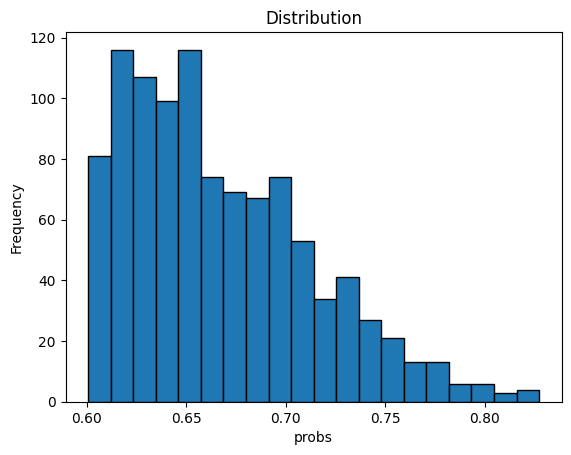

In [27]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# nw template dataset, sold

In [28]:
import random

# List of common, short words which are likely to be single tokens in GPT-2
common_words = [
    "Apple", "Ball", "Car", "Dog", "Egg", "Fish", "Gold", "Hat", "Ink", "Jar",
    "Kite", "Lamp", "Moon", "Nest", "Owl", "Pig", "Quilt", "Rat", "Sun", "Tree",
    "Umbrella", "Vase", "Wolf", "Yarn", "Zip", "Bird", "Cat", "Drum", "Frog",
    "Grape", "House", "Ice", "Juice", "Key", "Leaf", "Map", "Nut", "Orange",
    "Piano", "Queen", "Ring", "Star", "Train", "Van", "Whale", "Xylophone",
    "Yacht", "Zebra", "Ax", "Box", "Cow", "Desk", "Ear", "Fan", "Gate", "Hill",
    "Iron", "Joke", "King", "Lion", "Milk", "Nose", "Oil", "Pen", "Quiz", "Rose",
    "Shoe", "Tail", "Vine", "Wall", "Year", "Ant", "Bug", "Corn", "Duck", "Fire",
    "Grass", "Hand", "Island", "Jam", "Knee", "Lake", "Mouse", "Nail", "Pear",
    "Quack", "Road", "Sand", "Tent", "Valley", "Wind", "Yard", "Arm", "Boat",
    "Cake", "Door", "Eye", "Flag", "Horse", "Jeep", "Knife", "Light", "Mountain",
    "Night", "Ocean", "Plate", "Queen", "Rain", "Snow", "Tree", "Umbrella",
    "Valley", "Window", "Yogurt", "Zoo"
]

In [29]:
# List of various objects for random selection, ensuring each item is a single word
# single_word_objects = [
#     "apple", "ball", "chair", "desk", "elephant", "flower", "guitar", "hat", "jug", "kite",
#     "lamp", "mirror", "orange", "piano", "quilt", "ring", "television", "umbrella", "violin", "watch",
#     "yacht", "zebra", "book", "cup", "drone", "fridge", "gloves", "helmet", "igloo", "jacket",
#     "key", "lemon", "mug", "nail", "octopus", "pillow", "robot", "spoon", "tree", "unicorn",
#     "vase", "wheel", "yo-yo", "zipper", "backpack", "camera", "dumbbell", "envelope", "flashlight", "goggles",
#     "hammer", "ink", "jeans", "ladder", "microphone", "nest", "owl", "penguin", "quill", "ruler",
#     "scissors", "tent", "volcano", "wallet", "yogurt", "zucchini", "accordion", "bicycle", "candle", "dice",
#     "egg", "fan", "grapes", "horseshoe", "ice", "jar", "kettle", "leaf", "mask", "needle",
#     "oar", "peach", "quartz", "record", "saxophone", "toothbrush", "utensils", "vacuum", "wrench", "yarn",
#     "ashtray", "broom", "couch", "duck", "escalator", "figurine", "globe", "harp", "island", "jewel",
#     "kazoo", "lyre", "marble", "notepad", "opera", "pickle", "quartz", "raccoon", "saddle", "tulip"
# ] + [
#         "Balloon", "Bicycle", "Car", "Doll", "Eagle", "Flag", "Giraffe", "Helmet", "Igloo", "Jacket",
#         "Kite", "Lion", "Monkey", "Nest", "Oven", "Pencil", "Quill", "Rabbit", "Star", "Truck",
#         "Umbrella", "Violin", "Whale", "Xylophone", "Yak", "Zebra", "Apple", "Banana", "Camera", "Drum",
#         "Elephant", "Fork", "Glass", "House", "Island", "Jewel", "Kangaroo", "Lamp", "Mountain", "Notebook",
#         "Orange", "Piano", "Queen", "Rose", "Snake", "Tiger", "Urn", "Vase", "Window", "Xerox",
#         "Yoyo", "Zipper", "Anchor", "Brush", "Clock", "Dress", "Easel", "Fan", "Guitar", "Harp",
#         "Ink", "Jug", "Knife", "Leaf", "Mirror", "Nut", "Owl", "Penguin", "Quartz", "Ring",
#         "Spoon", "Table", "Ukulele", "Van", "Watch", "X-ray", "Yarn", "Zucchini", "Artichoke", "Broccoli",
#         "Cup", "Desk", "Egg", "Fridge", "Grape", "Hose", "Iris", "Jackal", "Kettle", "Lizard",
#         "Mango", "Napkin", "Ostrich", "Peacock", "Quokka", "Racoon", "Seal", "Tulip", "Urchin", "Violet"
#     ]

random_single_word_objects = [obj.capitalize() for obj in common_words]

In [30]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
random_single_word_objects = filter_to_single_token(random_single_word_objects)
len(random_single_word_objects)

65

In [31]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_to_num = {
    'January': 'one', 'February': 'two', 'March': 'three', 'April': 'four', 'May': 'five', 'June': 'six',
    'July': 'seven', 'August': 'eight', 'September': 'nine', 'October': 'ten', 'November': 'eleven', 'December': 'twelve'
    }
    months = [month_to_num[i] for i in months]
    prompts_list = []
    for j in range(1024): # this must come first else 1 2 3 overrepresented!
        for i in range(x, y):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} was sold in {months[i]}. {rand_words[1]} was sold in {months[i+1]}. {rand_words[2]} was sold in {months[i+2]}. {rand_words[3]} was sold in {months[i+3]}. {rand_words[4]} was sold in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, random_single_word_objects)

In [32]:
prompts_list[5000]

{'S1': 'one',
 'S2': 'two',
 'S3': 'three',
 'S4': 'four',
 'corr': ' five',
 'incorr': ' four',
 'text': 'Pear was sold in one. Iron was sold in two. Ice was sold in three. King was sold in four. Ax was sold in'}

In [33]:
example_prompt = prompts_list[5000]['text']
example_answer = prompts_list[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Pear', ' was', ' sold', ' in', ' one', '.', ' Iron', ' was', ' sold', ' in', ' two', '.', ' Ice', ' was', ' sold', ' in', ' three', '.', ' King', ' was', ' sold', ' in', ' four', '.', ' Ax', ' was', ' sold', ' in']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 20.56 Prob: 70.51% Token: | five|

Top 0th token. Logit: 20.56 Prob: 70.51% Token: | five|
Top 1th token. Logit: 18.85 Prob: 12.72% Token: | six|
Top 2th token. Logit: 17.86 Prob:  4.72% Token: | seven|
Top 3th token. Logit: 17.13 Prob:  2.27% Token: | ten|
Top 4th token. Logit: 16.99 Prob:  1.99% Token: | four|
Top 5th token. Logit: 16.71 Prob:  1.50% Token: | eight|
Top 6th token. Logit: 16.44 Prob:  1.14% Token: | one|
Top 7th token. Logit: 16.24 Prob:  0.93% Token: | three|
Top 8th token. Logit: 15.53 Prob:  0.46% Token: | two|
Top 9th token. Logit: 15.53 Prob:  0.46% Token: | nine|


Ranks of the answer tokens: [(' five', 0)]

In [34]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [35]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_prompts_sold.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_prompts_sold.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Tree was sold in two. Ocean was sold in three. Rain was sold in four. Tree was sold in five. Star was sold in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Zip was sold in three. Nut was sold in four. Iron was sold in five. Fan was sold in six. Pear was sold in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Rain was sold in four. Arm was sold in five. Flag was sold in six. Fish was sold in seven. Hill was sold in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Queen was sold in one. Year was sold in two. Mouse was sold in three. Pear was sold in four. King was sold in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Moon was sold in two. Light was sold in thre

Text(0.5, 1.0, 'Distribution')

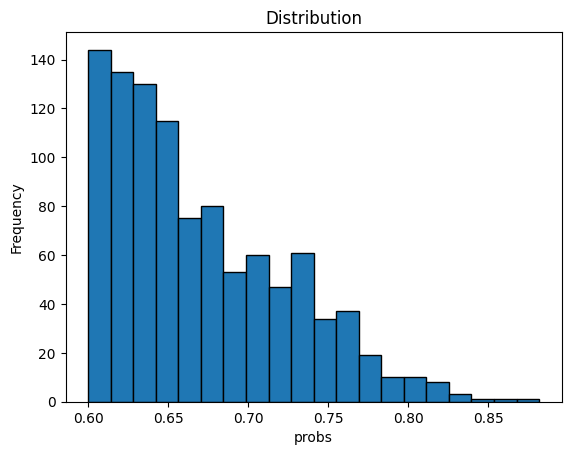

In [37]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# nw template dataset, made

In [38]:
import random

# List of common, short words which are likely to be single tokens in GPT-2
common_words = [
    "Apple", "Ball", "Car", "Dog", "Egg", "Fish", "Gold", "Hat", "Ink", "Jar",
    "Kite", "Lamp", "Moon", "Nest", "Owl", "Pig", "Quilt", "Rat", "Sun", "Tree",
    "Umbrella", "Vase", "Wolf", "Yarn", "Zip", "Bird", "Cat", "Drum", "Frog",
    "Grape", "House", "Ice", "Juice", "Key", "Leaf", "Map", "Nut", "Orange",
    "Piano", "Queen", "Ring", "Star", "Train", "Van", "Whale", "Xylophone",
    "Yacht", "Zebra", "Ax", "Box", "Cow", "Desk", "Ear", "Fan", "Gate", "Hill",
    "Iron", "Joke", "King", "Lion", "Milk", "Nose", "Oil", "Pen", "Quiz", "Rose",
    "Shoe", "Tail", "Vine", "Wall", "Year", "Ant", "Bug", "Corn", "Duck", "Fire",
    "Grass", "Hand", "Island", "Jam", "Knee", "Lake", "Mouse", "Nail", "Pear",
    "Quack", "Road", "Sand", "Tent", "Valley", "Wind", "Yard", "Arm", "Boat",
    "Cake", "Door", "Eye", "Flag", "Horse", "Jeep", "Knife", "Light", "Mountain",
    "Night", "Ocean", "Plate", "Queen", "Rain", "Snow", "Tree", "Umbrella",
    "Valley", "Window", "Yogurt", "Zoo"
]

In [39]:
# List of various objects for random selection, ensuring each item is a single word
# single_word_objects = [
#     "apple", "ball", "chair", "desk", "elephant", "flower", "guitar", "hat", "jug", "kite",
#     "lamp", "mirror", "orange", "piano", "quilt", "ring", "television", "umbrella", "violin", "watch",
#     "yacht", "zebra", "book", "cup", "drone", "fridge", "gloves", "helmet", "igloo", "jacket",
#     "key", "lemon", "mug", "nail", "octopus", "pillow", "robot", "spoon", "tree", "unicorn",
#     "vase", "wheel", "yo-yo", "zipper", "backpack", "camera", "dumbbell", "envelope", "flashlight", "goggles",
#     "hammer", "ink", "jeans", "ladder", "microphone", "nest", "owl", "penguin", "quill", "ruler",
#     "scissors", "tent", "volcano", "wallet", "yogurt", "zucchini", "accordion", "bicycle", "candle", "dice",
#     "egg", "fan", "grapes", "horseshoe", "ice", "jar", "kettle", "leaf", "mask", "needle",
#     "oar", "peach", "quartz", "record", "saxophone", "toothbrush", "utensils", "vacuum", "wrench", "yarn",
#     "ashtray", "broom", "couch", "duck", "escalator", "figurine", "globe", "harp", "island", "jewel",
#     "kazoo", "lyre", "marble", "notepad", "opera", "pickle", "quartz", "raccoon", "saddle", "tulip"
# ] + [
#         "Balloon", "Bicycle", "Car", "Doll", "Eagle", "Flag", "Giraffe", "Helmet", "Igloo", "Jacket",
#         "Kite", "Lion", "Monkey", "Nest", "Oven", "Pencil", "Quill", "Rabbit", "Star", "Truck",
#         "Umbrella", "Violin", "Whale", "Xylophone", "Yak", "Zebra", "Apple", "Banana", "Camera", "Drum",
#         "Elephant", "Fork", "Glass", "House", "Island", "Jewel", "Kangaroo", "Lamp", "Mountain", "Notebook",
#         "Orange", "Piano", "Queen", "Rose", "Snake", "Tiger", "Urn", "Vase", "Window", "Xerox",
#         "Yoyo", "Zipper", "Anchor", "Brush", "Clock", "Dress", "Easel", "Fan", "Guitar", "Harp",
#         "Ink", "Jug", "Knife", "Leaf", "Mirror", "Nut", "Owl", "Penguin", "Quartz", "Ring",
#         "Spoon", "Table", "Ukulele", "Van", "Watch", "X-ray", "Yarn", "Zucchini", "Artichoke", "Broccoli",
#         "Cup", "Desk", "Egg", "Fridge", "Grape", "Hose", "Iris", "Jackal", "Kettle", "Lizard",
#         "Mango", "Napkin", "Ostrich", "Peacock", "Quokka", "Racoon", "Seal", "Tulip", "Urchin", "Violet"
#     ]

random_single_word_objects = [obj.capitalize() for obj in common_words]

In [40]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
random_single_word_objects = filter_to_single_token(random_single_word_objects)
len(random_single_word_objects)

65

In [41]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_to_num = {
    'January': 'one', 'February': 'two', 'March': 'three', 'April': 'four', 'May': 'five', 'June': 'six',
    'July': 'seven', 'August': 'eight', 'September': 'nine', 'October': 'ten', 'November': 'eleven', 'December': 'twelve'
    }
    months = [month_to_num[i] for i in months]
    prompts_list = []
    for j in range(1024): # this must come first else 1 2 3 overrepresented!
        for i in range(x, y):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} was made in {months[i]}. {rand_words[1]} was made in {months[i+1]}. {rand_words[2]} was made in {months[i+2]}. {rand_words[3]} was made in {months[i+3]}. {rand_words[4]} was made in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, random_single_word_objects)

In [42]:
prompts_list[5000]

{'S1': 'one',
 'S2': 'two',
 'S3': 'three',
 'S4': 'four',
 'corr': ' five',
 'incorr': ' four',
 'text': 'Rat was made in one. Cow was made in two. Cat was made in three. King was made in four. Bird was made in'}

In [43]:
example_prompt = prompts_list[5000]['text']
example_answer = prompts_list[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Rat', ' was', ' made', ' in', ' one', '.', ' Cow', ' was', ' made', ' in', ' two', '.', ' Cat', ' was', ' made', ' in', ' three', '.', ' King', ' was', ' made', ' in', ' four', '.', ' Bird', ' was', ' made', ' in']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 20.44 Prob: 77.72% Token: | five|

Top 0th token. Logit: 20.44 Prob: 77.72% Token: | five|
Top 1th token. Logit: 18.14 Prob:  7.82% Token: | six|
Top 2th token. Logit: 17.23 Prob:  3.14% Token: | four|
Top 3th token. Logit: 17.17 Prob:  2.95% Token: | seven|
Top 4th token. Logit: 16.53 Prob:  1.57% Token: | ten|
Top 5th token. Logit: 16.42 Prob:  1.40% Token: | three|
Top 6th token. Logit: 16.41 Prob:  1.38% Token: | one|
Top 7th token. Logit: 15.53 Prob:  0.57% Token: | eight|
Top 8th token. Logit: 15.50 Prob:  0.56% Token: | two|
Top 9th token. Logit: 14.87 Prob:  0.30% Token: | fifteen|


Ranks of the answer tokens: [(' five', 0)]

In [44]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [45]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_prompts_made.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_prompts_made.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Tree was made in one. Light was made in two. Road was made in three. Mouse was made in four. Hat was made in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Pen was made in two. Tree was made in three. Box was made in four. Train was made in five. Car was made in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Sand was made in three. Snow was made in four. Box was made in five. Corn was made in six. Car was made in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Fan was made in four. Ear was made in five. Gold was made in six. Rose was made in seven. Cat was made in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Map was made in five. Gate was made in six. Li

Text(0.5, 1.0, 'Distribution')

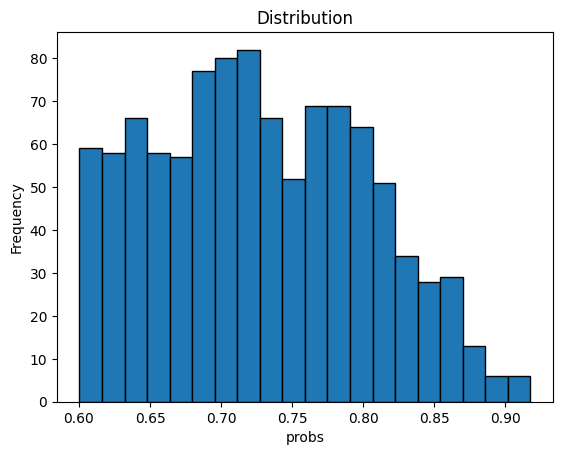

In [47]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# digits template dataset, sold

In [48]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Tree was sold in two. Ocean was sold in three. Rain was sold in four. Tree was sold in five. Star was sold in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Zip was sold in three. Nut was sold in four. Iron was sold in five. Fan was sold in six. Pear was sold in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Rain was sold in four. Arm was sold in five. Flag was sold in six. Fish was sold in seven. Hill was sold in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Queen was sold in one. Year was sold in two. Mouse was sold in three. Pear was sold in four. King was sold in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Moon was sold in two. Light was sold in thre

In [49]:
month_to_num = {'one': '1', 'two': '2', 'three': '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9', 'ten': '10', 'eleven': '11', 'twelve': '12'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': '2',
  'S2': '3',
  'S3': '4',
  'S4': '5',
  'corr': ' 6',
  'incorr': ' 5',
  'text': 'Tree was sold in 2. Ocean was sold in 3. Rain was sold in 4. Tree was sold in 5. Star was sold in'},
 {'S1': '3',
  'S2': '4',
  'S3': '5',
  'S4': '6',
  'corr': ' 7',
  'incorr': ' 6',
  'text': 'Zip was sold in 3. Nut was sold in 4. Iron was sold in 5. Fan was sold in 6. Pear was sold in'},
 {'S1': '4',
  'S2': '5',
  'S3': '6',
  'S4': '7',
  'corr': ' 8',
  'incorr': ' 7',
  'text': 'Rain was sold in 4. Arm was sold in 5. Flag was sold in 6. Fish was sold in 7. Hill was sold in'},
 {'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Queen was sold in 1. Year was sold in 2. Mouse was sold in 3. Pear was sold in 4. King was sold in'},
 {'S1': '2',
  'S2': '3',
  'S3': '4',
  'S4': '5',
  'corr': ' 6',
  'incorr': ' 5',
  'text': 'Moon was sold in 2. Light was sold in 3. Flag was sold in 4. Hill was sold in 5. Queen was sold in'},
 {'S1': '3',
 

In [50]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Cow', ' was', ' sold', ' in', ' 4', '.', ' Night', ' was', ' sold', ' in', ' 5', '.', ' Pen', ' was', ' sold', ' in', ' 6', '.', ' Apple', ' was', ' sold', ' in', ' 7', '.', ' Hand', ' was', ' sold', ' in']
Tokenized answer: [' 8']


Performance on answer token:
Rank: 0        Logit: 19.51 Prob: 88.77% Token: | 8|

Top 0th token. Logit: 19.51 Prob: 88.77% Token: | 8|
Top 1th token. Logit: 16.68 Prob:  5.21% Token: | 9|
Top 2th token. Logit: 15.89 Prob:  2.38% Token: | 10|
Top 3th token. Logit: 14.79 Prob:  0.79% Token: | 12|
Top 4th token. Logit: 14.25 Prob:  0.46% Token: | 7|
Top 5th token. Logit: 13.93 Prob:  0.33% Token: | 4|
Top 6th token. Logit: 13.84 Prob:  0.31% Token: | 14|
Top 7th token. Logit: 13.82 Prob:  0.30% Token: | 1|
Top 8th token. Logit: 13.27 Prob:  0.17% Token: | 11|
Top 9th token. Logit: 13.07 Prob:  0.14% Token: | 6|


Ranks of the answer tokens: [(' 8', 0)]

In [51]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [52]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_sold.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_sold.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '2', 'S2': '3', 'S3': '4', 'S4': '5', 'corr': ' 6', 'incorr': ' 5', 'text': 'Tree was sold in 2. Ocean was sold in 3. Rain was sold in 4. Tree was sold in 5. Star was sold in'}, {'S1': '3', 'S2': '4', 'S3': '5', 'S4': '6', 'corr': ' 7', 'incorr': ' 6', 'text': 'Zip was sold in 3. Nut was sold in 4. Iron was sold in 5. Fan was sold in 6. Pear was sold in'}, {'S1': '4', 'S2': '5', 'S3': '6', 'S4': '7', 'corr': ' 8', 'incorr': ' 7', 'text': 'Rain was sold in 4. Arm was sold in 5. Flag was sold in 6. Fish was sold in 7. Hill was sold in'}, {'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Queen was sold in 1. Year was sold in 2. Mouse was sold in 3. Pear was sold in 4. King was sold in'}, {'S1': '2', 'S2': '3', 'S3': '4', 'S4': '5', 'corr': ' 6', 'incorr': ' 5', 'text': 'Moon was sold in 2. Light was sold in 3. Flag was sold in 4. Hill was sold in 5. Queen was sold in'}, {'S1': '3', 'S2': '4', 'S3': '5', 'S4': '6', 'corr': ' 7', 'incorr': ' 6', 'te

Text(0.5, 1.0, 'Distribution')

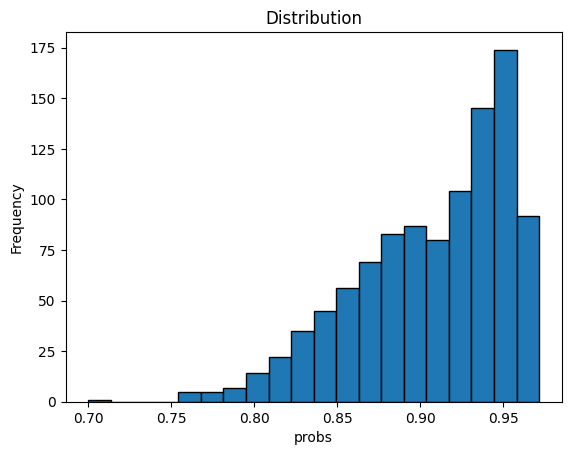

In [54]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# digits template dataset, names

In [55]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Aaron was born in two. Andrew was born in three. Ross was born in four. Richard was born in five. Steve was born in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Brandon was born in four. Eric was born in five. Ann was born in six. Craig was born in seven. Michelle was born in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Joe was born in five. Jason was born in six. Johnny was born in seven. David was born in eight. Jay was born in'}, {'S1': 'six', 'S2': 'seven', 'S3': 'eight', 'S4': 'nine', 'corr': ' ten', 'incorr': ' nine', 'text': 'Anna was born in six. Justin was born in seven. Mario was born in eight. Carl was born in nine. Jacob was born in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Anne was born in 

In [56]:
month_to_num = {'one': '1', 'two': '2', 'three': '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9', 'ten': '10', 'eleven': '11', 'twelve': '12'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': '2',
  'S2': '3',
  'S3': '4',
  'S4': '5',
  'corr': ' 6',
  'incorr': ' 5',
  'text': 'Aaron was born in 2. Andrew was born in 3. Ross was born in 4. Richard was born in 5. Steve was born in'},
 {'S1': '4',
  'S2': '5',
  'S3': '6',
  'S4': '7',
  'corr': ' 8',
  'incorr': ' 7',
  'text': 'Brandon was born in 4. Eric was born in 5. Ann was born in 6. Craig was born in 7. Michelle was born in'},
 {'S1': '5',
  'S2': '6',
  'S3': '7',
  'S4': '8',
  'corr': ' 9',
  'incorr': ' 8',
  'text': 'Joe was born in 5. Jason was born in 6. Johnny was born in 7. David was born in 8. Jay was born in'},
 {'S1': '6',
  'S2': '7',
  'S3': '8',
  'S4': '9',
  'corr': ' 10',
  'incorr': ' 9',
  'text': 'Anna was born in 6. Justin was born in 7. Mario was born in 8. Carl was born in 9. Jacob was born in'},
 {'S1': '2',
  'S2': '3',
  'S3': '4',
  'S4': '5',
  'corr': ' 6',
  'incorr': ' 5',
  'text': 'Anne was born in 2. Morgan was born in 3. Aaron was born in 4. Andrew was born in 5. Terry was

In [57]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Christian', ' was', ' born', ' in', ' 2', '.', ' Sarah', ' was', ' born', ' in', ' 3', '.', ' Stephen', ' was', ' born', ' in', ' 4', '.', ' Allen', ' was', ' born', ' in', ' 5', '.', ' Thomas', ' was', ' born', ' in']
Tokenized answer: [' 6']


Performance on answer token:
Rank: 0        Logit: 20.66 Prob: 97.08% Token: | 6|

Top 0th token. Logit: 20.66 Prob: 97.08% Token: | 6|
Top 1th token. Logit: 16.45 Prob:  1.44% Token: | 7|
Top 2th token. Logit: 15.00 Prob:  0.34% Token: | 8|
Top 3th token. Logit: 14.80 Prob:  0.28% Token: | 5|
Top 4th token. Logit: 14.08 Prob:  0.14% Token: | 10|
Top 5th token. Logit: 13.64 Prob:  0.09% Token: | 9|
Top 6th token. Logit: 13.55 Prob:  0.08% Token: | 11|
Top 7th token. Logit: 13.44 Prob:  0.07% Token: | six|
Top 8th token. Logit: 13.32 Prob:  0.06% Token: | 1|
Top 9th token. Logit: 13.25 Prob:  0.06% Token: | 4|


Ranks of the answer tokens: [(' 6', 0)]

In [58]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [59]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '2', 'S2': '3', 'S3': '4', 'S4': '5', 'corr': ' 6', 'incorr': ' 5', 'text': 'Aaron was born in 2. Andrew was born in 3. Ross was born in 4. Richard was born in 5. Steve was born in'}, {'S1': '4', 'S2': '5', 'S3': '6', 'S4': '7', 'corr': ' 8', 'incorr': ' 7', 'text': 'Brandon was born in 4. Eric was born in 5. Ann was born in 6. Craig was born in 7. Michelle was born in'}, {'S1': '5', 'S2': '6', 'S3': '7', 'S4': '8', 'corr': ' 9', 'incorr': ' 8', 'text': 'Joe was born in 5. Jason was born in 6. Johnny was born in 7. David was born in 8. Jay was born in'}, {'S1': '6', 'S2': '7', 'S3': '8', 'S4': '9', 'corr': ' 10', 'incorr': ' 9', 'text': 'Anna was born in 6. Justin was born in 7. Mario was born in 8. Carl was born in 9. Jacob was born in'}, {'S1': '2', 'S2': '3', 'S3': '4', 'S4': '5', 'corr': ' 6', 'incorr': ' 5', 'text': 'Anne was born in 2. Morgan was born in 3. Aaron was born in 4. Andrew was born in 5. Terry was born in'}, {'S1': '4', 'S2': '5', 'S3': '6', 'S4': '7', 'corr':

Text(0.5, 1.0, 'Distribution')

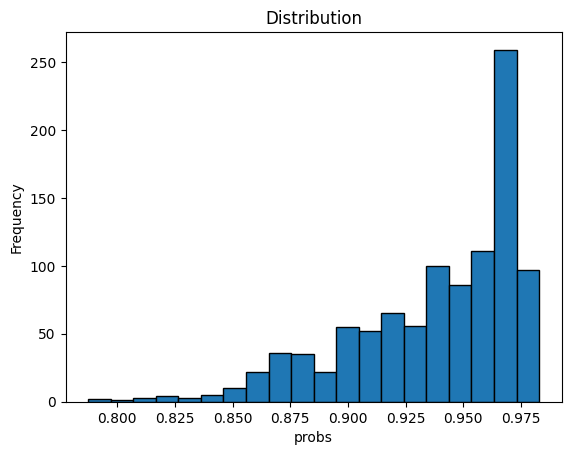

In [61]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# digits template dataset, made

In [62]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Tree was made in one. Light was made in two. Road was made in three. Mouse was made in four. Hat was made in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Pen was made in two. Tree was made in three. Box was made in four. Train was made in five. Car was made in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Sand was made in three. Snow was made in four. Box was made in five. Corn was made in six. Car was made in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Fan was made in four. Ear was made in five. Gold was made in six. Rose was made in seven. Cat was made in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Map was made in five. Gate was made in six. Li

In [63]:
month_to_num = {'one': '1', 'two': '2', 'three': '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9', 'ten': '10', 'eleven': '11', 'twelve': '12'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Tree was made in 1. Light was made in 2. Road was made in 3. Mouse was made in 4. Hat was made in'},
 {'S1': '2',
  'S2': '3',
  'S3': '4',
  'S4': '5',
  'corr': ' 6',
  'incorr': ' 5',
  'text': 'Pen was made in 2. Tree was made in 3. Box was made in 4. Train was made in 5. Car was made in'},
 {'S1': '3',
  'S2': '4',
  'S3': '5',
  'S4': '6',
  'corr': ' 7',
  'incorr': ' 6',
  'text': 'Sand was made in 3. Snow was made in 4. Box was made in 5. Corn was made in 6. Car was made in'},
 {'S1': '4',
  'S2': '5',
  'S3': '6',
  'S4': '7',
  'corr': ' 8',
  'incorr': ' 7',
  'text': 'Fan was made in 4. Ear was made in 5. Gold was made in 6. Rose was made in 7. Cat was made in'},
 {'S1': '5',
  'S2': '6',
  'S3': '7',
  'S4': '8',
  'corr': ' 9',
  'incorr': ' 8',
  'text': 'Map was made in 5. Gate was made in 6. Light was made in 7. Ant was made in 8. Hat was made in'},
 {'S1': '6',
  'S2': '7

In [64]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Rain', ' was', ' made', ' in', ' 1', '.', ' Map', ' was', ' made', ' in', ' 2', '.', ' Ant', ' was', ' made', ' in', ' 3', '.', ' Bug', ' was', ' made', ' in', ' 4', '.', ' Wind', ' was', ' made', ' in']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 17.60 Prob: 93.89% Token: | 5|

Top 0th token. Logit: 17.60 Prob: 93.89% Token: | 5|
Top 1th token. Logit: 13.53 Prob:  1.61% Token: | 6|
Top 2th token. Logit: 12.91 Prob:  0.87% Token: | 1|
Top 3th token. Logit: 12.17 Prob:  0.41% Token: | 7|
Top 4th token. Logit: 11.80 Prob:  0.28% Token: | 4|
Top 5th token. Logit: 11.39 Prob:  0.19% Token: | 10|
Top 6th token. Logit: 11.29 Prob:  0.17% Token: | 3|
Top 7th token. Logit: 10.97 Prob:  0.12% Token: |
|
Top 8th token. Logit: 10.78 Prob:  0.10% Token: | 9|
Top 9th token. Logit: 10.62 Prob:  0.09% Token: | 2|


Ranks of the answer tokens: [(' 5', 0)]

In [65]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [66]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_made.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_made.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Tree was made in 1. Light was made in 2. Road was made in 3. Mouse was made in 4. Hat was made in'}, {'S1': '2', 'S2': '3', 'S3': '4', 'S4': '5', 'corr': ' 6', 'incorr': ' 5', 'text': 'Pen was made in 2. Tree was made in 3. Box was made in 4. Train was made in 5. Car was made in'}, {'S1': '3', 'S2': '4', 'S3': '5', 'S4': '6', 'corr': ' 7', 'incorr': ' 6', 'text': 'Sand was made in 3. Snow was made in 4. Box was made in 5. Corn was made in 6. Car was made in'}, {'S1': '4', 'S2': '5', 'S3': '6', 'S4': '7', 'corr': ' 8', 'incorr': ' 7', 'text': 'Fan was made in 4. Ear was made in 5. Gold was made in 6. Rose was made in 7. Cat was made in'}, {'S1': '5', 'S2': '6', 'S3': '7', 'S4': '8', 'corr': ' 9', 'incorr': ' 8', 'text': 'Map was made in 5. Gate was made in 6. Light was made in 7. Ant was made in 8. Hat was made in'}, {'S1': '6', 'S2': '7', 'S3': '8', 'S4': '9', 'corr': ' 10', 'incorr': ' 9', 'text': 'Bu

Text(0.5, 1.0, 'Distribution')

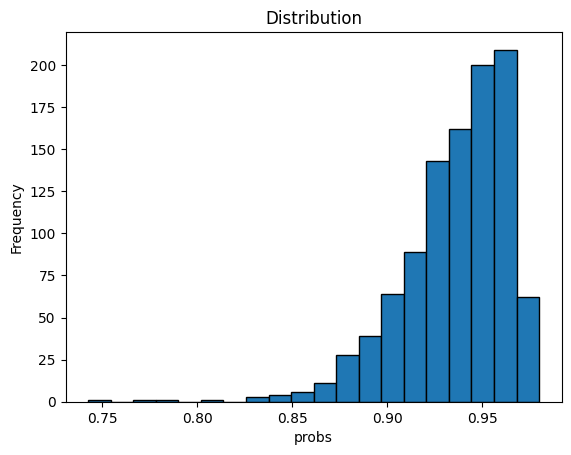

In [68]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# months template dataset, sold

In [69]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Tree was sold in two. Ocean was sold in three. Rain was sold in four. Tree was sold in five. Star was sold in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Zip was sold in three. Nut was sold in four. Iron was sold in five. Fan was sold in six. Pear was sold in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Rain was sold in four. Arm was sold in five. Flag was sold in six. Fish was sold in seven. Hill was sold in'}, {'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Queen was sold in one. Year was sold in two. Mouse was sold in three. Pear was sold in four. King was sold in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Moon was sold in two. Light was sold in thre

In [70]:
month_to_num = {'one': 'January', 'two': 'February', 'three': 'March', 'four': 'April', 'five': 'May', 'six': 'June', 'seven': 'July', 'eight': 'August', 'nine': 'September', 'ten': 'October', 'eleven': 'November', 'twelve': 'December'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': 'February',
  'S2': 'March',
  'S3': 'April',
  'S4': 'May',
  'corr': ' June',
  'incorr': ' May',
  'text': 'Tree was sold in February. Ocean was sold in March. Rain was sold in April. Tree was sold in May. Star was sold in'},
 {'S1': 'March',
  'S2': 'April',
  'S3': 'May',
  'S4': 'June',
  'corr': ' July',
  'incorr': ' June',
  'text': 'Zip was sold in March. Nut was sold in April. Iron was sold in May. Fan was sold in June. Pear was sold in'},
 {'S1': 'April',
  'S2': 'May',
  'S3': 'June',
  'S4': 'July',
  'corr': ' August',
  'incorr': ' July',
  'text': 'Rain was sold in April. Arm was sold in May. Flag was sold in June. Fish was sold in July. Hill was sold in'},
 {'S1': 'January',
  'S2': 'February',
  'S3': 'March',
  'S4': 'April',
  'corr': ' May',
  'incorr': ' April',
  'text': 'Queen was sold in January. Year was sold in February. Mouse was sold in March. Pear was sold in April. King was sold in'},
 {'S1': 'February',
  'S2': 'March',
  'S3': 'April',
  'S4': 

In [71]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Cow', ' was', ' sold', ' in', ' April', '.', ' Night', ' was', ' sold', ' in', ' May', '.', ' Pen', ' was', ' sold', ' in', ' June', '.', ' Apple', ' was', ' sold', ' in', ' July', '.', ' Hand', ' was', ' sold', ' in']
Tokenized answer: [' August']


Performance on answer token:
Rank: 0        Logit: 21.93 Prob: 86.73% Token: | August|

Top 0th token. Logit: 21.93 Prob: 86.73% Token: | August|
Top 1th token. Logit: 19.44 Prob:  7.18% Token: | September|
Top 2th token. Logit: 18.68 Prob:  3.35% Token: | October|
Top 3th token. Logit: 17.26 Prob:  0.81% Token: | December|
Top 4th token. Logit: 16.75 Prob:  0.49% Token: | July|
Top 5th token. Logit: 16.55 Prob:  0.40% Token: | Aug|
Top 6th token. Logit: 15.94 Prob:  0.22% Token: | November|
Top 7th token. Logit: 15.16 Prob:  0.10% Token: | early|
Top 8th token. Logit: 15.05 Prob:  0.09% Token: | April|
Top 9th token. Logit: 14.97 Prob:  0.08% Token: | February|


Ranks of the answer tokens: [(' August', 0)]

In [72]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [73]:
import pickle

# Saving the dictionary to a file using pickle
with open('months_prompts_sold.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('months_prompts_sold.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_sold.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'February', 'S2': 'March', 'S3': 'April', 'S4': 'May', 'corr': ' June', 'incorr': ' May', 'text': 'Tree was sold in February. Ocean was sold in March. Rain was sold in April. Tree was sold in May. Star was sold in'}, {'S1': 'March', 'S2': 'April', 'S3': 'May', 'S4': 'June', 'corr': ' July', 'incorr': ' June', 'text': 'Zip was sold in March. Nut was sold in April. Iron was sold in May. Fan was sold in June. Pear was sold in'}, {'S1': 'April', 'S2': 'May', 'S3': 'June', 'S4': 'July', 'corr': ' August', 'incorr': ' July', 'text': 'Rain was sold in April. Arm was sold in May. Flag was sold in June. Fish was sold in July. Hill was sold in'}, {'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Queen was sold in January. Year was sold in February. Mouse was sold in March. Pear was sold in April. King was sold in'}, {'S1': 'February', 'S2': 'March', 'S3': 'April', 'S4': 'May', 'corr': ' June', 'incorr': ' May', 'text': 'Moon wa

Text(0.5, 1.0, 'Distribution')

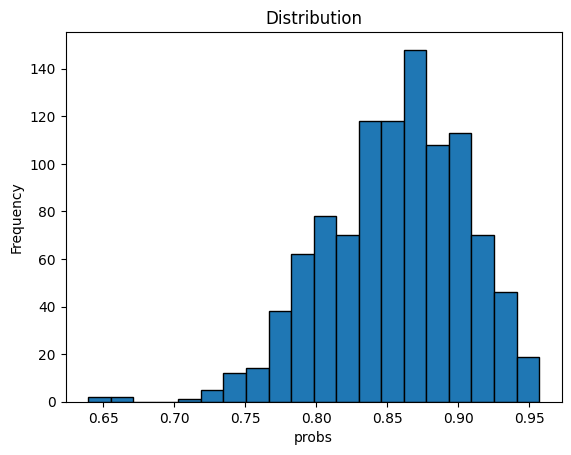

In [75]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# m template dataset, names

In [76]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Aaron was born in two. Andrew was born in three. Ross was born in four. Richard was born in five. Steve was born in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Brandon was born in four. Eric was born in five. Ann was born in six. Craig was born in seven. Michelle was born in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Joe was born in five. Jason was born in six. Johnny was born in seven. David was born in eight. Jay was born in'}, {'S1': 'six', 'S2': 'seven', 'S3': 'eight', 'S4': 'nine', 'corr': ' ten', 'incorr': ' nine', 'text': 'Anna was born in six. Justin was born in seven. Mario was born in eight. Carl was born in nine. Jacob was born in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Anne was born in 

In [77]:
month_to_num = {'one': 'January', 'two': 'February', 'three': 'March', 'four': 'April', 'five': 'May', 'six': 'June', 'seven': 'July', 'eight': 'August', 'nine': 'September', 'ten': 'October', 'eleven': 'November', 'twelve': 'December'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': 'February',
  'S2': 'March',
  'S3': 'April',
  'S4': 'May',
  'corr': ' June',
  'incorr': ' May',
  'text': 'Aaron was born in February. Andrew was born in March. Ross was born in April. Richard was born in May. Steve was born in'},
 {'S1': 'April',
  'S2': 'May',
  'S3': 'June',
  'S4': 'July',
  'corr': ' August',
  'incorr': ' July',
  'text': 'Brandon was born in April. Eric was born in May. Ann was born in June. Craig was born in July. Michelle was born in'},
 {'S1': 'May',
  'S2': 'June',
  'S3': 'July',
  'S4': 'August',
  'corr': ' September',
  'incorr': ' August',
  'text': 'Joe was born in May. Jason was born in June. Johnny was born in July. David was born in August. Jay was born in'},
 {'S1': 'June',
  'S2': 'July',
  'S3': 'August',
  'S4': 'September',
  'corr': ' October',
  'incorr': ' September',
  'text': 'Anna was born in June. Justin was born in July. Mario was born in August. Carl was born in September. Jacob was born in'},
 {'S1': 'February',
  'S2': 'M

In [78]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Christian', ' was', ' born', ' in', ' February', '.', ' Sarah', ' was', ' born', ' in', ' March', '.', ' Stephen', ' was', ' born', ' in', ' April', '.', ' Allen', ' was', ' born', ' in', ' May', '.', ' Thomas', ' was', ' born', ' in']
Tokenized answer: [' June']


Performance on answer token:
Rank: 0        Logit: 22.12 Prob: 73.46% Token: | June|

Top 0th token. Logit: 22.12 Prob: 73.46% Token: | June|
Top 1th token. Logit: 19.78 Prob:  7.08% Token: | October|
Top 2th token. Logit: 19.59 Prob:  5.84% Token: | August|
Top 3th token. Logit: 19.23 Prob:  4.07% Token: | July|
Top 4th token. Logit: 18.89 Prob:  2.92% Token: | May|
Top 5th token. Logit: 18.51 Prob:  1.99% Token: | September|
Top 6th token. Logit: 18.41 Prob:  1.80% Token: | November|
Top 7th token. Logit: 17.89 Prob:  1.07% Token: | December|
Top 8th token. Logit: 17.46 Prob:  0.69% Token: | April|
Top 9th token. Logit: 16.45 Prob:  0.25% Token: | February|


Ranks of the answer tokens: [(' June', 0)]

In [79]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.4 and probs[1] < 0.3:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


KeyboardInterrupt: ignored

In [ ]:
print(len(good_prompts))

In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('months_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('months_prompts_names.pkl')

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# m template dataset, made

In [80]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Tree was made in one. Light was made in two. Road was made in three. Mouse was made in four. Hat was made in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Pen was made in two. Tree was made in three. Box was made in four. Train was made in five. Car was made in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Sand was made in three. Snow was made in four. Box was made in five. Corn was made in six. Car was made in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Fan was made in four. Ear was made in five. Gold was made in six. Rose was made in seven. Cat was made in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Map was made in five. Gate was made in six. Li

In [81]:
month_to_num = {'one': 'January', 'two': 'February', 'three': 'March', 'four': 'April', 'five': 'May', 'six': 'June', 'seven': 'July', 'eight': 'August', 'nine': 'September', 'ten': 'October', 'eleven': 'November', 'twelve': 'December'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': 'January',
  'S2': 'February',
  'S3': 'March',
  'S4': 'April',
  'corr': ' May',
  'incorr': ' April',
  'text': 'Tree was made in January. Light was made in February. Road was made in March. Mouse was made in April. Hat was made in'},
 {'S1': 'February',
  'S2': 'March',
  'S3': 'April',
  'S4': 'May',
  'corr': ' June',
  'incorr': ' May',
  'text': 'Pen was made in February. Tree was made in March. Box was made in April. Train was made in May. Car was made in'},
 {'S1': 'March',
  'S2': 'April',
  'S3': 'May',
  'S4': 'June',
  'corr': ' July',
  'incorr': ' June',
  'text': 'Sand was made in March. Snow was made in April. Box was made in May. Corn was made in June. Car was made in'},
 {'S1': 'April',
  'S2': 'May',
  'S3': 'June',
  'S4': 'July',
  'corr': ' August',
  'incorr': ' July',
  'text': 'Fan was made in April. Ear was made in May. Gold was made in June. Rose was made in July. Cat was made in'},
 {'S1': 'May',
  'S2': 'June',
  'S3': 'July',
  'S4': 'August',
  

In [82]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Rain', ' was', ' made', ' in', ' January', '.', ' Map', ' was', ' made', ' in', ' February', '.', ' Ant', ' was', ' made', ' in', ' March', '.', ' Bug', ' was', ' made', ' in', ' April', '.', ' Wind', ' was', ' made', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 21.04 Prob: 90.22% Token: | May|

Top 0th token. Logit: 21.04 Prob: 90.22% Token: | May|
Top 1th token. Logit: 17.57 Prob:  2.81% Token: | June|
Top 2th token. Logit: 17.16 Prob:  1.86% Token: | July|
Top 3th token. Logit: 16.68 Prob:  1.14% Token: | November|
Top 4th token. Logit: 16.62 Prob:  1.08% Token: | April|
Top 5th token. Logit: 16.11 Prob:  0.65% Token: | September|
Top 6th token. Logit: 15.57 Prob:  0.38% Token: | March|
Top 7th token. Logit: 15.48 Prob:  0.34% Token: | October|
Top 8th token. Logit: 15.32 Prob:  0.29% Token: | late|
Top 9th token. Logit: 14.80 Prob:  0.18% Token: | early|


Ranks of the answer tokens: [(' May', 0)]

In [83]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 0.6 and probs[1] < 0.2:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [84]:
import pickle

# Saving the dictionary to a file using pickle
with open('months_prompts_made.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('months_prompts_made.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'months_prompts_made.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'January', 'S2': 'February', 'S3': 'March', 'S4': 'April', 'corr': ' May', 'incorr': ' April', 'text': 'Tree was made in January. Light was made in February. Road was made in March. Mouse was made in April. Hat was made in'}, {'S1': 'February', 'S2': 'March', 'S3': 'April', 'S4': 'May', 'corr': ' June', 'incorr': ' May', 'text': 'Pen was made in February. Tree was made in March. Box was made in April. Train was made in May. Car was made in'}, {'S1': 'March', 'S2': 'April', 'S3': 'May', 'S4': 'June', 'corr': ' July', 'incorr': ' June', 'text': 'Sand was made in March. Snow was made in April. Box was made in May. Corn was made in June. Car was made in'}, {'S1': 'April', 'S2': 'May', 'S3': 'June', 'S4': 'July', 'corr': ' August', 'incorr': ' July', 'text': 'Fan was made in April. Ear was made in May. Gold was made in June. Rose was made in July. Cat was made in'}, {'S1': 'May', 'S2': 'June', 'S3': 'July', 'S4': 'August', 'corr': ' September', 'incorr': ' August', 'text': 'Map was 

Text(0.5, 1.0, 'Distribution')

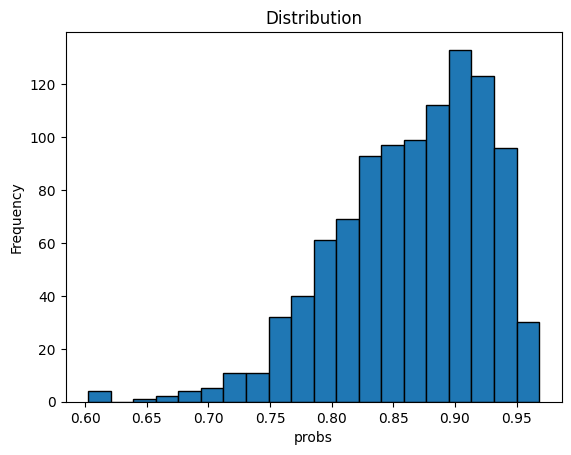

In [86]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')